# Tutorial on Stock Data Analysis

## Introduction
### Why do we care about stocks?
It is inevitable that we will all have to at least touch the market at some point with our investment accounts for retirement, education, etc. It is important to understand at least at a high level what is happening in an industry that virutally all people will be exposed to some point in their life. You do not need to understand how the stock market at a deep level to understand the relevancy of the topic. The simplest concept that one should understand about the application of data science in finance is the rise of [quantitative analysts](https://en.wikipedia.org/wiki/Quantitative_analyst) or quant.
### What is quant?
The essential definition of quant is the application of statistics and mathematics in finance and more recently the application of data science and machine learning. The traditional role of quant was for [derivative](https://en.wikipedia.org/wiki/Derivative_(finance)) pricing and other asset or risk management calculations. However, recently with the rise of machine learning and data analysis on almost all databases in virtually every industry, people are trying to apply ML and data science to the tradition buying/selling of stocks with quant resulting in a new area called [quant trading](https://www.investopedia.com/terms/q/quantitative-trading.asp). 
### Some examples and further readings and research into quant trading
Quant trading has an extremely long way to go until it can possibly be at the same level as humans. One of quant's biggest flaws and advantages is the separation of emotion or sentiment in its algorithms. Because computers can't process the emotional stress of a stock falling or the excitement of a stock rising, it won't make an irrational decisions, such as panic selling or pouring an unrealistical amount of money into a stock that you think will rise. At the same time however, quant traders have difficulty comprehending events involving a company and understanding whether it will cause a stock to rise or fall. For example, we cann ntake something like Apple and them unveiling a new iPhone that is more expensive than expected. You would have to first see if people will either buy or sell Apple stock in hopes of it doing well or doing poorly and modify a quant algorithm to somehow implement that into its algorithm. Using the following links you can learn more about quant and some applications:
- [Quant Trading Wikipedia](https://www.investopedia.com/terms/q/quantitative-trading.asp)
- [Basics of Quant](https://www.quantstart.com/articles/Beginners-Guide-to-Quantitative-Trading)

The reality is that the quant field is undeveloped and there hasn't been much success in its use, which is why a huge number of companies investing into it.

### This tutorial
We won't be applying any quant techniques and will be doing much more basic operations using pandas, the quant trading concepts are just ideas to be thinking about when trying to query a bit more on the data. Pandas cannot handle all of the data that is in the dataset that we are using, but later it may be appropriate to do operations on specific ticker symbols or industries for actual application.

### We will be working with the last 20 years of stock market data from [Kaggle](https://www.kaggle.com/tsaustin/us-historical-stock-prices-with-earnings-data).
This dataset has a gzipped CSV file, ```dataset_summary.csv.gz``` in the first folder with summary statistics (metadata).

### Onto the Real Data...
```stocks_latest``` folder contains files with the actual market data with the following files (gzippped CSVs)<br><br>
```dividends_latest.csv.gz``` has all [dividends](https://www.investopedia.com/terms/d/dividend.asp) of the companies that have had dividend payouts.<br>
```earnings_latest.csv.gz``` has all [earnings](https://www.investopedia.com/terms/e/earnings.asp) data attributes like quarters, expected vs actual earnings per share (EPS), release time (post or pre market).
```stock_prices_latest.csv.gz``` has stock prices with information such as open price, low, high, trading volume, etc. We will not be doing analysis on this.

## Installing Dependencies
We will use ```pip3 install -r "requirements.txt```, which will install all necessary dependencies

In [1]:
import csv
import gzip
import sqlite3
import pandas as pd
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os

## Load data into a DB
We will put this information into a SQLite database to demonstrate basic SQL queries.

### Determine the columns
We could open up the csvs and manually find the columns, but we can instead use pandas to figure out the columns of each of the files. Pandas allows us to read csvs and with the respective file paths being passed in, we can convert it to a tuple, to later use in string formatting when we create the tables in our database.

In [2]:
def load_columns(summary_filepath, dividends_filepath, earnings_filepath):
    # Pandas allows us to read csvs, nrows=0 returns us the top row, which ar the column names
    sumcols = tuple(", ".join(pd.read_csv(summary_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
    dcols = tuple(", ".join(pd.read_csv(dividends_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
    ecols = tuple(", ".join(pd.read_csv(earnings_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
    # Printing all of the columns
    print(sumcols)
    print(dcols)
    print(ecols)

# These are the paths to the files that we pass in
load_columns('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')
    

('symbol', ' total_prices', ' stock_from_date', ' stock_to_date', ' total_earnings', ' earnings_from_date', ' earnings_to_date')
('symbol', ' date', ' dividend')
('symbol', ' date', ' qtr', ' eps_est', ' eps', ' release_time')


### Load into a SQlite3 DB
Now that we know the columns, we can load it into a SQlite3 DB.

In [3]:
def load_data_into_db(summary_filepath, dividends_filepath, earnings_filepath):
    conn = sqlite3.connect(":memory:")
    # conn.text_factory = str
    c = conn.cursor()
    # Create columns again
    sumcols = (", ".join(pd.read_csv(summary_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
    dcols = (", ".join(pd.read_csv(dividends_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
    ecols = (", ".join(pd.read_csv(earnings_filepath, nrows=0, compression='gzip', error_bad_lines=False)).split(','))
  
    # Making the summary table
    e = ("CREATE TABLE summary (%s TEXT, %s INTEGER, %s DATE, %s DATE, %s INTEGER, %s DATE, %s DATE)" %tuple(sumcols))
    c.execute(e)
    with gzip.open(summary_filepath, mode="rt", encoding ='utf-8') as f:
        dr = csv.DictReader(f)
        to_db = [(i['symbol'], i['total_prices'], i['stock_from_date'], i['stock_to_date'], i['total_earnings'], i['earnings_from_date'], i['earnings_to_date']) for i in dr]
    e = ("INSERT INTO summary (%s, %s, %s, %s, %s, %s, %s) VALUES (?, ?, ?, ?, ?, ?, ?);" %tuple(sumcols))
    c.executemany(e, to_db)
    
    # Making the dividends table
    e = ("CREATE TABLE dividends (%s TEXT, %s DATE, %s FLOAT)" %tuple(dcols))
    c.execute(e)
    with gzip.open(dividends_filepath, mode="rt", encoding ='utf-8') as f:
        dr = csv.DictReader(f)
        to_db = [(i['symbol'], i['date'], i['dividend']) for i in dr]
    e = ("INSERT INTO dividends (%s, %s, %s) VALUES (?, ?, ?);" %tuple(dcols))
    c.executemany(e, to_db)
    
    # Making the earnings table
    e = ("CREATE TABLE earnings (%s TEXT, %s DATE, %s DATE, %s FLOAT, %s FLOAT, %s TEXT)" %tuple(ecols))
    c.execute(e)
    with gzip.open(earnings_filepath, mode="rt", encoding ='utf-8') as f:
        dr = csv.DictReader(f)
        to_db = [(i['symbol'], i['date'], i['qtr'], i['eps_est'], i['eps'], i['release_time']) for i in dr]
    e = ("INSERT INTO earnings (%s, %s, %s, %s, %s, %s) VALUES (?, ?, ?, ?, ?, ?);" %tuple(ecols))
    c.executemany(e, to_db)
    return conn
    
load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

### Starting some basic analysis
Now that we know our connection to the sqlite3 server works, and that the tables are in the database. Let's gather some aggregate statistics on the summary data (metadata) of the companies. 

### Dividend Payouts
Dividend payouts are payouts that companies give to investors as a reward for buying their company's shares, some companies decide not to have as many payouts as others but that's another concepts behind business that we do not have to get into. <br>
##### How do we do this?
We can do a simple SQL operation to find out what companies have historically had the largest dividend pay outs. 

In [4]:
def highest_dividend(conn, num): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("Highest Dividend Pay Outs and When They Were Paid")
    query = """SELECT d.symbol AS "Ticker Symbol", d.date AS "Date", d.dividend AS "Dividend Pay Out in Dollars"
                FROM dividends as d
                ORDER BY d.dividend DESC
                LIMIT %d""" %num
    print(pd.read_sql_query(query, conn, index_col = None))
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_dividend(conn, 10)

Highest Dividend Pay Outs and When They Were Paid
  Ticker Symbol        Date  Dividend Pay Out in Dollars
0         GOOGL  2014-04-03                     567.9717
1           GHC  2015-07-01                     425.5000
2           KSU  2000-07-13                     181.0000
3         NRCIB  2013-05-23                     178.5400
4           BBH  2009-04-01                     167.1520
5             Y  1998-06-18                     143.4375
6           ALX  2012-12-21                     122.0000
7           KDP  2018-07-10                     103.7500
8         FWONA  2014-07-24                      92.0000
9            KF  2008-12-29                      90.3000


##### Is this useful information as an investor?
It may be nice to know who has had the high dividend payout but is not a very pracitcal query as it doesn't show us much. Taking this one step further, a skewed statistic of someone having the highest dividend is not useful if as an investor. A company paying out a high dividend in the past dividend does not necessarily mean that they will pay out more later. It could have been the case that the company had a really good quarter or season but now does not see any growth and as a result, an investor should not put money in that company.<br>
##### What query would be appropriate for this?
As a result, we want to find out if a company has been consistently putting out 

In [5]:
def highest_avg_dividend(conn, num): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("Average Dividend Pay Outs and Number of Pay Outs:")
    query = """SELECT d.symbol AS "Ticker Symbol", AVG(d.dividend) AS "Average Dividend Pay out in Dollars", COUNT(d.dividend) AS "Number of Pay Outs"
                FROM dividends as d
                GROUP BY d.symbol
                ORDER BY AVG(d.dividend) DESC
                LIMIT %d""" %num
    print(pd.read_sql_query(query, conn, index_col = None))
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_avg_dividend(conn, 10)

Average Dividend Pay Outs and Number of Pay Outs:
  Ticker Symbol  Average Dividend Pay out in Dollars  Number of Pay Outs
0         GOOGL                           567.971700                   1
1            ZG                            58.293500                   1
2          MSGN                            47.957100                   1
3          HMSY                            47.500100                   1
4           OIS                            46.126500                   1
5            VC                            43.400000                   1
6         DISCB                            41.170000                   1
7         DISCK                            39.780000                   1
8         FWONA                            39.362367                   3
9           PNK                            38.860000                   1


#### Anything strange?
We notice that the number of payouts for all the highest averages are very low! This is not good because the whole point that we did averages was to find out the companies that have the most consistent outputs. <br>
There are a couple things that we can do: 
- we can weigh the higher number of payouts more with some function that values more payouts as more valuable
- have a set number of minimum payouts that a company needs to have for us to consider investors for the sake of high payouts
We will try both of these strategies

In [6]:
def highest_avg_dividend_mod(conn, num, minpay): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("[Weighing higher payouts linearly]")
    query = """SELECT d.symbol AS "Ticker", AVG(d.dividend) AS "Avg Dividend", COUNT(d.dividend) AS "# of Pay Outs", AVG(d.dividend)*COUNT(d.dividend) AS "Linearly Calculated Weight"
                FROM dividends as d
                GROUP BY d.symbol
                ORDER BY AVG(d.dividend)*COUNT(d.dividend) DESC
                LIMIT %d""" %num
    print(pd.read_sql_query(query, conn, index_col = None))
    print()
    print("[Setting Minimum Pay Outs (%d)]" %minpay)
    query = """SELECT d.symbol AS "Ticker", AVG(d.dividend) AS "Avg Dividend", COUNT(d.dividend) AS "Payouts"
                FROM dividends as d
                GROUP BY d.symbol
                HAVING COUNT(d.dividend) >= %d
                ORDER BY AVG(d.dividend) DESC
                LIMIT %d""" %(minpay, num)
    print(pd.read_sql_query((query), conn, index_col = None))
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_avg_dividend_mod(conn, 10, 5)

[Weighing higher payouts linearly]
  Ticker  Avg Dividend  # of Pay Outs  Linearly Calculated Weight
0  HBANP     21.207615             39                    827.0970
1    GHC      6.851882             85                    582.4100
2  GOOGL    567.971700              1                    567.9717
3    ALX      6.705128             39                    261.5000
4      Y     15.316964             14                    214.4375
5     NC      2.343520             88                    206.2298
6    BBH      5.141565             40                    205.6626
7  NRCIB      4.053125             48                    194.5500
8    KSU      4.997368             38                    189.9000
9   GYRO     23.453750              8                    187.6300

[Setting Minimum Pay Outs (5)]
  Ticker  Avg Dividend  Payouts
0   GYRO     23.453750        8
1  HBANP     21.207615       39
2    TDG     18.916667        6
3      Y     15.316964       14
4    CKH      8.062456        9
5   DHIL      7

#### Better Result?
If we wanted to invest in a company that had high payouts, good thing we didn't buy the companies of strictly highest payouts; we know the companies that we determined in these past two queries are ones that have relatively good payouts over a consistent period. We can modify the parameters as much as we want to get as many payouts as we can. In fact we will do a query on just that.

In [7]:
def highest_number_dividends(conn, num): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("[Max Payouts]")
    query = """SELECT d.symbol AS "Ticker", AVG(d.dividend) AS "Avg Dividend", COUNT(d.dividend) AS "Payouts"
                FROM dividends as d
                GROUP BY d.symbol
                ORDER BY COUNT(d.dividend) DESC
                LIMIT %d""" %(num)
    print(pd.read_sql_query((query), conn, index_col = None))
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_number_dividends(conn, 10)

[Max Payouts]
  Ticker  Avg Dividend  Payouts
0    PPH      0.100778      301
1    GIM      0.055892      287
2    HIO      0.050812      270
3    CXH      0.048632      269
4    KTF      0.064102      269
5    AWF      0.100243      268
6    NMT      0.062288      266
7    CRT      0.190543      265
8    DSM      0.044867      265
9    MMT      0.040699      265


#### Conclusion of Determining Good Dividends
The data that this tutorial provides is quite minimal, but the possibilities are limitless when determining the validity and strengh of a certain stock from a company. As shown above, it may be good to buy companies that seem to have very consistent payouts to have more reliablility in dividends if that is what a particular investor is looking for.<br>
You are encouraged to think about other ways to analyze dividends using some kind of weighing mechanism or some other way you see fit. It may be appropriate to work with only on company to see dividend trends and be able to analyze other trends, such as company performance over time and factor that into your calculations and education on whether you want to invest in a specific company.

### Earnings Analysis
Now in terms of actual investing, it may not be the best idea to only look at dividend payouts, especially if a company is not growing. Even if a company does not pay out dividends, if they are growing over the course of owning a stock, the investor will obtain more capital in the end.<br>
An important factor in determing whether a company does well is their quarterly earnings reports, which tell us if a company hits [expectations](https://www.investopedia.com/terms/e/earningsreport.asp) (based on analysts' expectations). If a company continues to impress the public with increasingly hitting beyond expectations, it may attract that company's stock. 
#### Initial queries
We will begin with a very simple query that simply shows us the top earnings of companies 

In [8]:
def highest_earnings(conn, num): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("Best EPS performance")
    query = """SELECT e.symbol AS "Ticker Symbol", e.qtr AS "Quarter", e.eps AS "EPS (earnings per share)"
                FROM earnings as e
                WHERE e.eps <> 'NULL'
                ORDER BY e.eps DESC
                LIMIT %d""" %num
    print(pd.read_sql_query(query, conn, index_col = None))
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_earnings(conn, 10)

Best EPS performance
  Ticker Symbol  Quarter  EPS (earnings per share)
0          DCIX  06/2014                    987.54
1          DCIX  09/2014                    987.54
2          NSPR  12/2012                    961.54
3          SAEX  12/2013                    918.92
4          DRYS  06/2015                    704.00
5          DCIX  12/2012                    493.77
6          DCIX  12/2014                    493.77
7          DCIX  06/2015                    493.77
8          SAEX  06/2014                    378.38
9          SAEX  06/2015                    378.38


#### Is this useful?
As we realized on the last analysis on the dividends, just getting the best earnings report is not necessarily the best piece of evidence to look at for the performance of the company. Similar to the dividends, a company could have one really quarter and destroyed expectations for their earnings, but this does not mean it is consistently beating expectetations 
#### What should we look at then?
We not only need to look at the averages of expectation reports, but we have to look at the difference in terms of how much the company beat the analysts' expectations by. Sometimes companies early on are not profitable but if they are performing better than analysts' expectations, it is valid for an investor to put money into the company since it will grow even if they are techincally not profitable currently. We will now create a query on the averages of how much the stocks beat expectations by.

In [9]:
def highest_earnings(conn, num): # cursor is the sqlite3 cursor, num is number of companies we will display
    print("Best expected EPS (earnings per share) performance and what quarter it happened")
    query = """SELECT e.symbol AS "Ticker Symbol", e.qtr, AVG(e.eps - e.eps_est) AS "Amount that beat expectations (dollars)"
                FROM earnings as e
                WHERE (e.eps_est <> 'NULL') AND (e.eps <> 'NULL')
                GROUP BY e.symbol
                ORDER BY AVG(e.eps - e.eps_est) DESC
                LIMIT %d""" %num
    print(pd.read_sql_query(query, conn, index_col = None))
    print()
    
conn = load_data_into_db('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

highest_earnings(conn, 10)

Best expected EPS (earnings per share) performance and what quarter it happened
  Ticker Symbol      qtr  Amount that beat expectations (dollars)
0          INPX  03/2014                                63.518462
1          DCIX  09/2012                                49.327000
2          SPEX  09/2012                                21.100000
3          NSPR  09/2013                                12.110000
4          AEZS  09/2012                                 7.567391
5           ANY  12/2014                                 6.232727
6          NCNA       Q4                                 5.975000
7            BH  09/2012                                 5.590000
8          PSTV       Q2                                 4.630000
9          DAVA  12/2018                                 3.283500



#### Conclusion of Earnings Analysis
Again, like the dividend analysis, earnings are similar in that you can start graphing trends and create other factors to consider when thinking of investing in a specific company's stock. Earnings reports also have sentiment tied to them and experience with exposing yourself with people's reactions on earnigns reports may help you make more educated decisions on how much to weigh an earnings report. For example, for the most part, a surpassing of expectations causes people to expect people to buy, which also allows for a margin of short selling, where you take advantage of the spike that people get from an earnings report. 
##### Other Ideas
Other concepts that can be touched upon are seeing if post or pre market release of earnings reports are independent of each other or if companies tend to do post market release or earnings if it is good or bad. <br>
You can also explore the concept of people sometimes overvaluing unprofitable companies when their earnings reports show it beating analyst expectations. This dips into the concept of analysts and investors overvaluing startups and other tech companies that are build on hype a lot of the time. Prime examples are when [unicorns](https://www.investopedia.com/terms/u/unicorn.asp) IPO and valuations are overvalued, or companies such as [Tesla](https://en.wikipedia.org/wiki/Tesla,_Inc.) whose stocks are truly built on mostly hype and not actual valuation. 

## Visualizations
We will now make some visualizations of important information about these companies and statistics that we may want to consider. We will use pandas dataframes to easy use [matplotlib](http://matplotlib.org) to graph them.

### Load up data
We have to load up the data as a dataframe via pandas, since we need to graph it.

In [10]:
def load_data_pandas(summary_filepath, dividends_filepath, earnings_filepath):
    sum_df = pd.read_csv(summary_filepath, compression='gzip', error_bad_lines=False)
    div_df = pd.read_csv(dividends_filepath, compression='gzip', error_bad_lines=False)
    ear_df = pd.read_csv(earnings_filepath, compression='gzip', error_bad_lines=False)
    # We return the data as dataframes to use matplotlib
    return (sum_df, div_df, ear_df)

load_data_pandas('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')

(     symbol  total_prices stock_from_date stock_to_date  total_earnings  \
 0         A          4962      1999-11-18    2019-08-09              42   
 1        AA           697      2016-11-01    2019-08-09              11   
 2      AAAP           574      2015-11-11    2018-07-18               0   
 3      AABA          5434      1998-01-02    2019-08-07              14   
 4       AAC          1222      2014-10-02    2019-08-09              21   
 5       AAL          3489      2005-09-27    2019-08-07              23   
 6      AAMC          1675      2012-12-13    2019-08-09              23   
 7      AAME          5434      1998-01-02    2019-08-07              39   
 8       AAN          5436      1998-01-02    2019-08-09              41   
 9      AAOI          1476      2013-09-26    2019-08-07              24   
 10     AAON          5434      1998-01-02    2019-08-07              41   
 11      AAP          4454      2001-11-29    2019-08-09              42   
 12     AAPL

### Graphing Example
We will use matplotlib to give an example of data that we can graph.

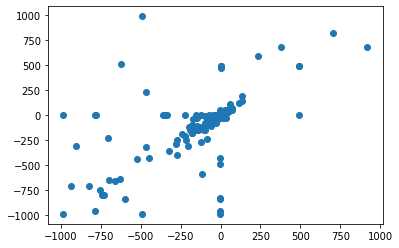

In [11]:
def example_plot(ear_df):
    x = []
    y = []
    for i in range (len(ear_df)):
        cury = ear_df.loc[i, 'eps_est']
        curx = ear_df.loc[i, 'eps']
        if cury != 0 and curx != 0:
            y.append(cury)
            x.append(curx)
    return plt.scatter(x, y)

(sum_df, div_df, ear_df) = load_data_pandas('dataset_summary.csv.gz', 'stocks_latest/dividends_latest.csv.gz', 
                                 'stocks_latest/earnings_latest.csv.gz')
p = example_plot(ear_df)
plt.show()

#### Observations
This graph tells us a few things about the eps vs expected eps. It vaguely tells us that the relationship betweenn the expected EPS and the actual EPS is around x = y which implies that the expected and actual are very similar. We can also try to graph this on a specific set of companies or company to see trends for them or a specific industry.

### Conclusion
Overall, we can use even this metadata to make certain observation and predictions about trends in the market. Trying to get more insights about these statistics and discovering trends is all part of the process of getting comfortable with thinking about the stock market and potentially quant if that is also an interest. 